In [441]:
import os
import ast
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import swifter
from tqdm import tqdm
import yaml

from socialvec.socialvec import SocialVec

tqdm.pandas()

# Infer on Sagi's data

In [442]:
import ast
from socialvec.socialvec import SocialVec
import pandas as pd
import pickle
import swifter

In [443]:
import sys
sys.path.append('models')
from custom_loss import label_smoothing_loss

In [444]:
# gender - "models/Gender_2020_230807.pkl"
model_path = 'models/Political_2020_230816.pkl'

In [445]:
with open(model_path, 'rb') as file:
    # Load the pickled object using pickle.load()
    cls_model = pickle.load(file)

In [389]:
sv = SocialVec(cls_model['SocialVec_version'])

✅  Initialize Model[?25h
✅  Load Metadata[?25h


In [390]:
df = pd.read_pickle('../../working_area/sagi/242K_political_users_with_followees.pkl', compression='gzip')

## select a random sample

In [391]:
df_attribues = pd.read_csv('../../working_area/sagi/242k_users_all_attributes.csv.gz',compression='gzip')

df_attribues['user_id'] = df_attribues['user_id'].astype('str')
df = pd.merge(df, df_attribues, on='user_id')

df = df.sample(n=5000)

In [392]:
df.shape

(242004, 50)

## or select previously selected file

In [ ]:
#df = pd.read_excel('artifacts/classification_with_gpt.xlsx')
df_sg = pd.read_excel('artifacts/sagi_Sample_with_gender_v1.xlsx')
df_sg.drop(columns=['Unnamed: 0','SocialVec_len','gender_prediction','gender_confidence','predicted_label'], inplace=True)
df_sg.rename(columns={'political_tweets_x':'political_tweets','collected_tweets_x':'collected_tweets'},inplace=True)
df['user_id'] = df['user_id'].astype(int)
df = pd.merge(df_sg,df[['user_id','friends_ids']], on='user_id')

## continue to process

In [312]:
def parse_and_flatten_me(arr):
    arr = ast.literal_eval(arr)
    try:
        return arr[0]
    except:
        return arr
    
df["friends_ids"]=df["friends_ids"].swifter.apply(parse_and_flatten_me)

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

## infer on subset pmi

In [313]:
def get_sv( friends_ids ):
    friends_ids_subset = [x for x in friends_ids if x in cls_model['relevant_accounts']]
    return sv.get_average_embeddings(friends_ids_subset)

df[['SocialVec', 'SocialVec_len']] = df.swifter.apply(
    lambda x: get_sv(x['friends_ids']), axis=1, result_type="expand")

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

In [314]:
df[df['SocialVec_len']>=10].shape[0]

2775

In [315]:
df.shape

(5000, 52)

In [316]:
print(f"when filtering socialVec_len>10 we lose { df[df['SocialVec_len']<10].shape[0]} of the data")

df = df[df['SocialVec_len']>=10]

when filtering socialVec_len>10 we lose 2225 of the data


### Predict

In [317]:
values = np.stack(df['SocialVec'].to_numpy())
X = tf.constant(values)

preds = cls_model['model'].predict(X)

df[f"{cls_model['attribute']}_prediction"] = tf.argmax(preds, axis=1)
df[f"{cls_model['attribute']}_confidence"] = np.max(preds, axis=1)


87/87 [==============================] - 0s 2ms/step


/tmp/ipykernel_4913/3276307817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_prediction'] = tf.argmax(preds, axis=1)
/tmp/ipykernel_4913/3276307817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_confidence'] = np.max(preds, axis=1)


In [318]:
df['predicted_label'] = cls_model['labels'].inverse_transform(df[f"{cls_model['attribute']}_prediction"])

/tmp/ipykernel_4913/2680030106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_label'] = cls_model['labels'].inverse_transform(df['gender_prediction'])


In [319]:
df.drop(columns=['SocialVec'], inplace=True)

/tmp/ipykernel_4913/1498718575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['SocialVec'], inplace=True)


In [320]:
df = df[df[f"{cls_model['attribute']}_confidence"]>=0.9]

In [322]:
from tqdm import tqdm
tqdm.pandas()

In [323]:
def get_name(account_name):
    try:
        return sv.get_screen_name(account_name)
    except:
        return ''

In [324]:
account_list = list(cls_model['relevant_accounts'])

In [325]:
account_list_str = []
for ac in account_list:
    account_list_str.append(str(ac))

In [326]:
account_mapping = {}

for ac in tqdm(account_list_str):
    account_mapping[ac] = get_name(ac)


100%|██████████| 20000/20000 [11:43<00:00, 28.41it/s]


In [327]:
def get_friends_account_names(friends_ids):
    friends_ids_subset = [str(x) for x in friends_ids if x in cls_model['relevant_accounts']]
    friends_names = [account_mapping[x] for x in friends_ids_subset]
    return friends_names

In [328]:

# def get_friends_account_names(friends_ids):
#     friends_ids_subset = [x for x in friends_ids if x in cls_model['relevant_accounts']]
#     friends_names = [ get_name(x) for x in friends_ids_subset]
#     return friends_names

df['relevant_accounts'] = df['friends_ids'].swifter.apply(get_friends_account_names)
df.drop(columns=['friends_ids'], inplace=True)

Pandas Apply:   0%|          | 0/1755 [00:00<?, ?it/s]

In [329]:
df.to_excel('artifacts/sagi_Sample_with_political_v2.xlsx')

# Infer on all of Sagi's data

In [446]:
df = pd.read_pickle('../../working_area/sagi/242K_political_users_with_followees.pkl', compression='gzip')

In [447]:
df_attribues = pd.read_csv('../../working_area/sagi/242k_users_all_attributes.csv.gz',compression='gzip')

df_attribues['user_id'] = df_attribues['user_id'].astype('str')
df = pd.merge(df, df_attribues, on='user_id')


In [ ]:
def parse_and_flatten_me(arr):
    arr = ast.literal_eval(arr)
    try:
        return arr[0]
    except:
        return arr
    
df["friends_ids"]=df["friends_ids"].swifter.apply(parse_and_flatten_me)

In [ ]:
def get_sv( friends_ids ):
    friends_ids_subset = [x for x in friends_ids if x in cls_model['relevant_accounts']]
    return sv.get_average_embeddings(friends_ids_subset)

df[['SocialVec', 'SocialVec_len']] = df.swifter.apply(
    lambda x: get_sv(x['friends_ids']), axis=1, result_type="expand")

In [450]:
print(f"Initial number of users {df.shape[0]:,}")
print(f"Number of users with SocialVec_len>10 {df[df['SocialVec_len']>=10].shape[0]:,}")

Initial number of users 242,004
Number of users with SocialVec_len>10 135,305


In [451]:
df = df[df['SocialVec_len']>=10]

### Predict

In [ ]:
values = np.stack(df['SocialVec'].to_numpy())
X = tf.constant(values)

preds = cls_model['model'].predict(X)

df[f"{cls_model['attribute']}_prediction"] = tf.argmax(preds, axis=1)
df[f"{cls_model['attribute']}_confidence"] = np.max(preds, axis=1)

In [453]:
txt = f"{cls_model['attribute']}_confidence"
print(f"Number of users with confidence>0.9: {df[df[txt]>0.9].shape[0]:,}")

Number of users with confidence>0.9: 85,083


In [454]:
df = df[df[txt]>0.9]

In [455]:
df['predicted_label'] = cls_model['labels'].inverse_transform(df[f"{cls_model['attribute']}_prediction"])

In [456]:
df['predicted_label'].value_counts(normalize=True)

Republican   0.514
Democrat     0.486
Name: predicted_label, dtype: float64

In [353]:
import seaborn as sns

<AxesSubplot: xlabel='political_tweets_x', ylabel='Density'>

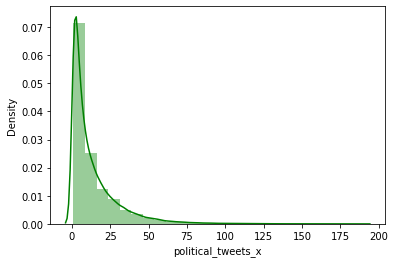

In [354]:
sns.distplot(df['political_tweets_x'], bins=25, color="g")

In [ ]:
from statsmodels.stats.weightstats import ztest as ztest

In [457]:
class1 = df['predicted_label'].unique()[0]
class2 = df['predicted_label'].unique()[1]

print(f"class1 is {class1}, class2 is {class2}")

class1 is Democrat, class2 is Republican


In [361]:
ztest(df[df['predicted_label']==class1]['political_tweets_x'].values,
      df[df['predicted_label']==class2]['political_tweets_x'].values)

(-22.99088465949304, 5.750547130257188e-117)

In [362]:
ztest(df[df['predicted_label']==class1]['into_tweets_%_collected_tweets'].values,
      df[df['predicted_label']==class2]['into_tweets_%_collected_tweets'].values)


(-3.1549012703522834, 0.0016055242617860894)

In [364]:
df[df['predicted_label']==class1]['into_tweets_%_collected_tweets'].mean()

2.8222905830275464

In [365]:
df[df['predicted_label']==class2]['into_tweets_%_collected_tweets'].mean()

2.932057758191577

Since this p-value is less than .05, we have sufficient evidence to reject the null hypothesis. In other words, the mean level of political_tweets is significantly different between the two genders.

<AxesSubplot: xlabel='political_tweets_x', ylabel='Count'>

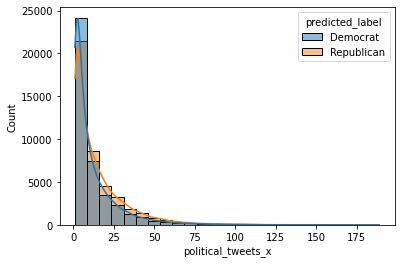

In [366]:
sns.histplot(data=df, x='political_tweets_x', 
             bins=25, color="g",
             hue='predicted_label',
             cumulative = False,
             thresh=1000,
             kde=True,
            common_norm = False)


In [ ]:
df.columns

In [ ]:
hist_values, bin_edges = np.histogram(df[df['predicted_label']=='Female']['political_tweets_x'], bins=50)  # Adjust the number of bins as needed
hist_df = pd.DataFrame({'bin_edges': bin_edges[:-1], 'hist_occurrences': hist_values})

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.bar(hist_df['bin_edges'], hist_df['hist_occurrences'], width=bin_edges[1] - bin_edges[0])

In [ ]:
plt.bar(hist_df['bin_edges'], hist_df['hist_occurrences'], width=bin_edges[1] - bin_edges[0])

* check ratio political


In [458]:
df.rename(columns={"political_tweets_x":"political_tweets","collected_tweets_x":"collected_tweets"}, inplace=True)

In [459]:
df['political_ratio'] = df['political_tweets']/df['collected_tweets']
df['intollerant_ratio'] = df['into_tweets']/df['political_tweets']
df['impolite_ratio'] = df['impo_tweets']/df['political_tweets']
df['uncivil_ratio'] = (df['into_tweets']+df['impo_tweets'])/df['political_tweets']

In [460]:
df1 = df[df["predicted_label"]==class1].copy()
df2 = df[df["predicted_label"]==class2].copy()

In [461]:
interesting_columns = [ 'political_tweets',	'collected_tweets',	'into_tweets',	'impo_tweets',
                       'political_ratio',	'intollerant_ratio',
                       'impolite_ratio',	'uncivil_ratio']

In [462]:
population2.shape

(16660,)

In [464]:
for columns_to_check in interesting_columns:
    population1 = df1[columns_to_check].values
    population2 = df2[columns_to_check].values

    t_statistic, p_value = stats.ttest_ind(population1, population2)
    t_statistic, p_value2 = ztest(population1, population2)
    print(f"{columns_to_check};{np.mean(population2):.3f};{np.mean(population1):.3f};{t_statistic:.2f};{p_value:.5f};{p_value2:.5f}")

political_tweets;14.878;12.247;-22.99;0.00000;0.00000
collected_tweets;129.495;121.026;-20.43;0.00000;0.00000
into_tweets;3.581;2.923;-16.98;0.00000;0.00000
impo_tweets;4.693;3.442;-30.41;0.00000;0.00000
political_ratio;0.121;0.115;-7.79;0.00000;0.00000
intollerant_ratio;0.202;0.198;-2.41;0.01580;0.01580
impolite_ratio;0.311;0.297;-7.02;0.00000;0.00000
uncivil_ratio;0.512;0.495;-6.64;0.00000;0.00000


In [468]:
df.drop(columns=['friends_ids','political_prediction_new', 'NumOfPopular_political_new',
       'gender_prediction_label', 'gender_prediction', 'NumOfPopular_gender',
       'age_prediction_label', 'age_prediction', 'NumOfPopular_age',
       'children_prediction_label', 'children_prediction',
       'NumOfPopular_children', 'education_prediction_label',
       'education_prediction', 'NumOfPopular_education',
       'income_prediction_label', 'income_prediction', 'NumOfPopular_income',
       'race_prediction_label', 'race_prediction', 'NumOfPopular_race',
       'political_prediction_label_old', 'political_prediction_old',
       'NumOfPopular_political_old', 'SocialVec', 'SocialVec_len','Unnamed: 0','favourites_count',
                'friends_count','followers_count','verified','listed_count','statuses_count',
                'created_at','collected_at','political_prediction_label_new', 'Political_prediction',
                'collected_tweets_y','political_tweets_y',
                'into_tweets_%_political','impo_tweets_%_political','political_%_collected_tweets',
                'into_tweets_%_collected_tweets','impo_tweets_%_collected_tweets']).to_excel('242k_political.xlsx')

<AxesSubplot: xlabel='impolite_ratio', ylabel='Count'>

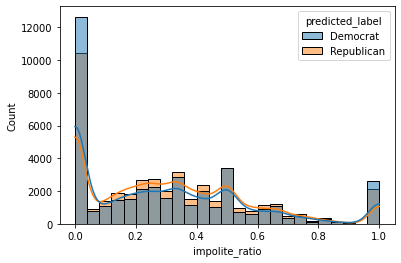

In [383]:
sns.histplot(data=df, x='impolite_ratio', 
             bins=25, color="g",
             hue='predicted_label',
             cumulative = False,
             thresh=1000,
             kde=True,
            common_norm = False)


# Compare with Einat's calculations

In [ ]:
df_subset = pd.read_excel('artifacts/sagi_Sample_with_gender_v2.xlsx')

In [ ]:
df_subset['political_ratio'] = df_subset['political_tweets']/df_subset['collected_tweets']
df_subset['intollerant_ratio'] = df_subset['into_tweets']/df_subset['political_tweets']
df_subset['impolite_ratio'] = df_subset['impo_tweets']/df_subset['political_tweets']
df_subset['uncivil_ratio'] = (df_subset['into_tweets']+df_subset['impo_tweets'])/df_subset['political_tweets']

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df_subset.groupby(by="predicted_label").sum().T

In [ ]:
1.5 / 9.23

In [ ]:
df_subset.groupby(by="predicted_label").std().T

In [ ]:
import scipy.stats as stats

In [ ]:
df1 = df_subset[df_subset["predicted_label"]=="Male"].copy()
df2 = df_subset[df_subset["predicted_label"]=="Female"].copy()

In [ ]:
interesting_columns = [ 'political_tweets',	'collected_tweets',	'into_tweets',	'impo_tweets',
                       'political_ratio',	'intollerant_ratio',
                       'impolite_ratio',	'uncivil_ratio']

In [ ]:
for columns_to_check in interesting_columns:
    population1 = df1[columns_to_check].values
    population2 = df2[columns_to_check].values

    t_statistic, p_value = stats.ttest_ind(population1, population2)
    t_statistic, p_value2 = ztest(population1, population2)
    print(f"{columns_to_check};{np.mean(population2):.3f};{np.mean(population1):.3f};{t_statistic:.2f};{p_value:.5f};{p_value2:.5f}")

In [ ]:
ztest(population1, population2)[1]

# Back to the full dataset

In [ ]:
#df.rename(columns={'collected_tweets_x':'collected_tweets'},inplace=True)

In [ ]:
df['political_ratio'] = df['political_tweets']/df['collected_tweets']
df['intollerant_ratio'] = df['into_tweets']/df['political_tweets']
df['impolite_ratio'] = df['impo_tweets']/df['political_tweets']
df['uncivil_ratio'] = (df['into_tweets']+df['impo_tweets'])/df['political_tweets']

In [ ]:
df.groupby(by="predicted_label").mean().T

In [ ]:
df1 = df[df["predicted_label"]=="Male"].copy()
df2 = df[df["predicted_label"]=="Female"].copy()

In [ ]:
columns_to_check = 'uncivil_ratio'

population1 = df1[columns_to_check].values
population2 = df2[columns_to_check].values

t_statistic, p_value = stats.ttest_ind(population1, population2)
p_value